In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import warnings
import pandas as pd

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#fdb462',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [3]:
import glob
import os
import sys
sys.path.append('../../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

In [4]:
# SN2013bh
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA

with open("./SN2013bh_lc.dat") as f:
    lines = f.readlines()

z = float(lines[0].split("=")[-1])
ebv = float(lines[1].split("=")[-1])
mu = float(lines[2].split("=")[-1].split("+/-")[0])
t_max_mjd = float(lines[3].split("=")[-1].split(")")[0])
mjd = np.array([float(i) for i in lines[5].split()]) + 2456000 - 2400000.5
phase = (mjd - t_max_mjd) / (1 + z)

t_fl = (370.02 + 375.02) / 2 + 2456000 - 2400000.5
phase_fl = (mjd - t_fl) / (1 + z)

g, r, i = np.empty_like(mjd), np.empty_like(mjd), np.empty_like(mjd)
g_err, r_err, i_err = (
    np.empty_like(mjd),
    np.empty_like(mjd),
    np.empty_like(mjd),
)
for k in range(3):
    lc = [g, r, i][k]
    lc_err = [g_err, r_err, i_err][k]
    lc_str = lines[7 + 2 * k].split()
    for j in range(len(lc_str)):
        if "···" in lc_str[j]:
            lc[j], lc_err[j] = np.nan, np.nan
        else:
            lc[j], lc_err[j] = float(lc_str[j].split("(")[0]) - mu, float(
                lc_str[j].split("(")[-1].split(")")[0]
            )

g = g - calALambda(wv=leff_g, EBV=ebv, RV=3.1)
r = r - calALambda(wv=leff_r, EBV=ebv, RV=3.1)
i = i - calALambda(wv=leff_i, EBV=ebv, RV=3.1)

In [5]:
def syn_color(wv, F_mean, flt1, flt2):

    flt1, flt2 = np.loadtxt(flt1), np.loadtxt(flt2)

    f0_1 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt1)[0]
    f0_2 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt2)[0]
    color = -2.5 * np.log10(f0_1 / f0_2)

    return color

In [6]:
def K_corr(z, wv, F_mean, flt1, flt2):
    """
    Calculate the synthetic K-correction as a function of z
    """

    flt1, flt2 = np.loadtxt(flt1), np.loadtxt(flt2)

    f0_1 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt1)[0]
    f0_2 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt2)[0]
    f_ratio_z_1 = (
        f0_1
        / spec_to_flux(
            spec=[
                wv * (1 + z),
                F_mean / (1 + z),
                np.ones_like(wv, dtype=float),
            ],
            flt=flt1,
        )[0]
    )
    f_ratio_z_2 = (
        f0_2
        / spec_to_flux(
            spec=[
                wv * (1 + z),
                F_mean / (1 + z),
                np.ones_like(wv, dtype=float),
            ],
            flt=flt2,
        )[0]
    )
    # K-corr in single bands
    K_corrs_1 = -2.5 * np.log10(f_ratio_z_1)
    K_corrs_2 = -2.5 * np.log10(f_ratio_z_2)
    # K-corr in the flt1 - flt2 color
    K_corrs_12 = K_corrs_1 - K_corrs_2

    return K_corrs_1, K_corrs_2, K_corrs_12

../../spectroscopy/SN2013bh/SN2013bh_2013-04-01_00-00-00_HET_HET-LRS_TS3.flm
-3.6 ../../spectroscopy/SN2013bh/SN2013bh_2013-04-01_00-00-00_HET_HET-LRS_TS3.flm
K(g) = -0.01, K(r) = 0.18, K(g-r) = -0.19
../../spectroscopy/SN2013bh/SN2013bh_2013-04-06_00-00-00_HET_HET-LRS_TS3.flm
1.2 ../../spectroscopy/SN2013bh/SN2013bh_2013-04-06_00-00-00_HET_HET-LRS_TS3.flm
K(g) = -0.04, K(r) = 0.24, K(g-r) = -0.28
../../spectroscopy/SN2013bh/SN2013bh_2013-04-09_13-28-33_Keck1_LRIS_iPTF.flm
4.1 ../../spectroscopy/SN2013bh/SN2013bh_2013-04-09_13-28-33_Keck1_LRIS_iPTF.flm
K(g) = -0.05, K(r) = 0.30, K(g-r) = -0.35
../../spectroscopy/SN2013bh/SN2013bh_2013-04-11_00-00-00_HET_HET-LRS_TS3.flm
5.8 ../../spectroscopy/SN2013bh/SN2013bh_2013-04-11_00-00-00_HET_HET-LRS_TS3.flm
K(g) = -0.07, K(r) = 0.27, K(g-r) = -0.34
../../spectroscopy/SN2013bh/SN2013bh_2013-04-13_00-00-00_P200_DBSP_iPTF.flm
7.7 ../../spectroscopy/SN2013bh/SN2013bh_2013-04-13_00-00-00_P200_DBSP_iPTF.flm
K(g) = -0.02, K(r) = 0.35, K(g-r) = -0.37
.

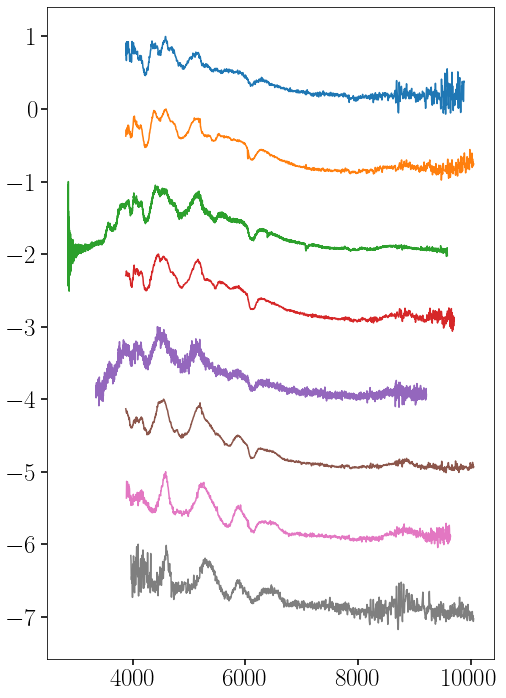

In [7]:
phases_syn = []
g_r_syn = []
K_corr_g, K_corr_r, K_corr_g_r = [], [], []
spec_files = sorted(glob.glob("../../spectroscopy/SN2013bh/*flm"))

plt.figure(figsize=(8, 12))

for k, spec in enumerate(spec_files):
    spec_df = pd.read_csv(spec, comment="#", delim_whitespace=True, header=None)

    try:
        if 'LRIS' in spec:
            fl_unc = spec_df[3].values
        else:
            fl_unc = spec_df[2].values
    except:
        # warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 5e-2 * np.median(spec_df[0].values)
    with open(spec) as f:
        ll = f.readlines()
    print(spec)
    for l in ll:
        if "phase" in l:
            phase_syn = float(l.split("=")[1])

    print(phase_syn, spec)
    plt.plot(spec_df[0].values / (1 + z),
        spec_df[1].values/spec_df[1].values.max() - k)
    flt1 = "../filters/P48_g.dat"
    flt2 = "../filters/P48_R.dat"
    K_corr_1, K_corr_2, K_corr_12 = K_corr(
        z,
        spec_df[0].values / (1 + z),
        spec_df[1].values,
        flt1,
        flt2,
    )
    print(
        "K(g) = {:.2f}, K(r) = {:.2f}, K(g-r) = {:.2f}".format(
            K_corr_1, K_corr_2, K_corr_12
        )
    )
    phases_syn = np.append(phases_syn, phase_syn)
    K_corr_g = np.append(K_corr_g, K_corr_1)
    K_corr_r = np.append(K_corr_r, K_corr_2)
    K_corr_g_r = np.append(K_corr_g_r, K_corr_12)

    g_r_syn = np.append(
        g_r_syn,
        syn_color(
            spec_df[0].values / (1 + 0.00807),
            spec_df[1].values,
            flt1,
            flt2,
        ),
    )

(-12.0, 30.0)

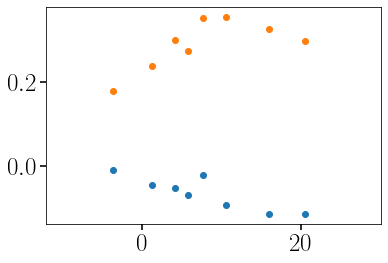

In [8]:
plt.scatter(phases_syn, K_corr_g)
plt.scatter(phases_syn, K_corr_r)
plt.xlim(-12, 30)

Initial negative log likelihood: -10.90402819006549
Gradient of the negative log likelihood, wrt the parameters:
{'log_amps': Array(1.20210233, dtype=float64), 'log_scales': Array(-3.09451867, dtype=float64)}
Final negative log likelihood: -11.826628482193321


(-20.0, 40.0)

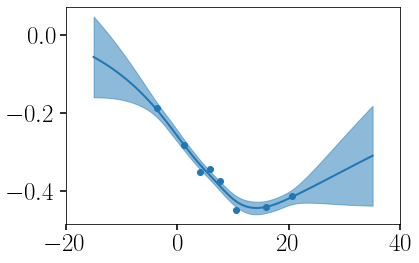

In [9]:
import jax
import jax.numpy as jnp

from tinygp import kernels, GaussianProcess


jax.config.update("jax_enable_x64", True)


def build_gp(theta, X):

    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    kernel = amps * kernels.Matern32(scales)

    return GaussianProcess(
        kernel, X, diag=0.02**2, mean=0
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)

theta_init = {
    "log_amps": np.log(0.1),
    "log_scales": np.log(25)
}

arg = ~np.isnan(K_corr_g_r) & (phases_syn < 100)
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))
print(f"Initial negative log likelihood: {obj(theta_init, phases_syn[arg], K_corr_g_r[arg])[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, phases_syn[arg], K_corr_g_r[arg])[1]}"
)

import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=phases_syn[arg], y=K_corr_g_r[arg])
print(f"Final negative log likelihood: {soln.state.fun_val}")

x = np.linspace(-15, 35, 100)
# gp = build_gp(soln.params, phases)
gp = build_gp(soln.params, phases_syn[arg])
cond_gp = gp.condition(K_corr_g_r[arg], x).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.scatter(phases_syn, K_corr_g_r)
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=2)
plt.xlim(-20, 40)

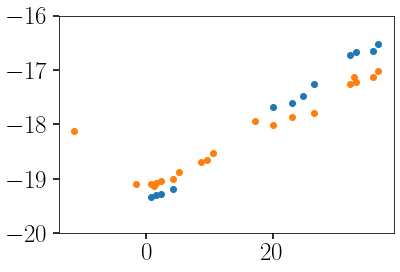

In [10]:
gp = build_gp(soln.params, phases_syn[arg])
cond_gp = gp.condition(K_corr_g[arg], phase).gp
g_corr = g + cond_gp.loc

gp = build_gp(soln.params, phases_syn[arg])
cond_gp = gp.condition(K_corr_r[arg], phase).gp
r_corr = r + cond_gp.loc

plt.scatter(phase, g_corr)
plt.scatter(phase, r_corr)

plt.gca().invert_yaxis()
plt.ylim(-20, -16)

np.savetxt(
    "SN2013bh_lc_Kcorr.dat",
    np.array([phase, g, g_corr, g_err, r, r_corr, r_err]).T,
    fmt="%.2f %.3f %.3f %.3f %.3f %.3f %.3f",
    header="phase g g(K_corr) g_err r r(K_corr) r_err"
)